In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [128]:
import numpy as np
import json
from equistore import Labels, TensorBlock, TensorMap, TensorSlice
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from rascal.representations import SphericalExpansion
import copy
from utils.pair_features import *

## Manipulate Hamiltonian into blocks

In [3]:
frames = ase.io.read("data/hamiltonian/water-hamiltonian/water_coords_1000.xyz",":20")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [4]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.loads(json.load(open('data/hamiltonian/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [5]:
hams = np.load("data/hamiltonian/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

blocks = dense_to_blocks(hams, frames, orbs)

In [6]:
cg = ClebschGordanReal(5)

In [7]:
coupled = couple_blocks(blocks, cg)

fock_bc = coupled

## Feature computation

In [8]:
rascal_hypers = {
    "interaction_cutoff": 2.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 4,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [9]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [10]:
mc_rho1i = acdc_standardize_keys(rhoi)
mc_rho1i.keys_to_properties(['species_neighbor'])
mc_gij =  acdc_standardize_keys(gij)

In [12]:
?cg_increment

In [13]:
%%time
mc_rho2i = cg_increment(mc_rho1i, mc_rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 120 ms, sys: 8.05 ms, total: 128 ms
Wall time: 126 ms


In [14]:
%%time
mc_rho3i = cg_increment(mc_rho2i, mc_rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 4.29 s, sys: 486 ms, total: 4.78 s
Wall time: 4.78 s


In [15]:
%%time
mc_rho1ij = cg_increment(mc_rho1i, mc_gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 141 ms


In [16]:
%%time
mc_rho2ij = cg_increment(mc_rho2i, mc_gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 6.09 s, sys: 915 ms, total: 7 s
Wall time: 7.2 s


In [17]:
%lprun -f cg_combine cg_increment(mc_rho2i, mc_gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [18]:
np.linalg.norm(mc_rho2i.block(0).values)
# 0.001486930385468841

0.0020953616386121064

In [20]:
ham_feats = hamiltonian_features(mc_rho3i, mc_rho2ij)

## Testing model on one structure

In [50]:
mc_rho2ij.block(0).samples.names

('structure', 'center', 'neighbor')

In [120]:
%%time
ts = TensorSlice(ham_feats,                  
                 Labels(names=["structure"], values=np.asarray([1,3,5,7,9], dtype=np.int32).reshape(-1,1)),
                 Labels(names=["species_neighbor_1", "species_neighbor_2"], values=np.asarray([[1,1],[1,8]], dtype=np.int32).reshape(-1,2)),
                )

CPU times: user 881 ms, sys: 0 ns, total: 881 ms
Wall time: 880 ms


In [123]:
ts.block(0).samples

Labels([(1, 1, 1), (1, 2, 2), (3, 1, 1), (3, 2, 2), (5, 1, 1), (5, 2, 2),
        (7, 1, 1), (7, 2, 2), (9, 1, 1), (9, 2, 2)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor', '<i4')])

In [121]:
%lprun -f TensorSlice TensorSlice(ham_feats, Labels(names=["structure"], values=np.asarray([1,3,5,7,9], dtype=np.int32).reshape(-1,1)), Labels(names=["species_neighbor_1", "species_neighbor_2"], values=np.asarray([[1,1],[1,8]], dtype=np.int32).reshape(-1,2)),)

In [22]:
from utils.Hamiltonian_model_utils import *

In [90]:
FR = Fock_regression(jorbs, alpha=1e-18)

In [91]:
FR.fit(TensorSlice(ham_feats, Labels(names=["structure"], values=np.asarray(range(10), dtype=np.int32).reshape(-1,1)) ),
       TensorSlice(fock_bc,  Labels(names=["structure"], values=np.asarray(range(10), dtype=np.int32).reshape(-1,1)) ))

In [92]:
pred = FR.predict(ham_feats)

In [93]:
for i in range(len(fock_bc.keys)):
    print(pred.keys[i])
    print(pred.block(i).values.flatten() - fock_bc.block(i).values.flatten())

(0, 8, 2, 0, 8, 2, 0, 0)
[ 4.71320044e-08 -6.37842528e-08  2.68430235e-07 -3.17285604e-08
  1.06961794e-06 -1.93051006e-07  1.78976802e-07 -7.14982497e-07
  1.64223808e-07 -7.01954268e-07 -1.95926202e-04 -4.81467938e-04
 -1.07633182e-04 -1.49969167e-04 -4.04661433e-04 -1.22724030e-03
  4.90702239e-03  2.70474904e-07  2.70875843e-07  6.23443807e-04]
(0, 8, 2, 0, 8, 2, 1, 1)
[ 2.35019478e-07 -2.92061474e-16 -9.74970251e-08 -6.15191266e-07
 -4.23050211e-17  7.27522836e-07  1.69716310e-17  2.63949760e-08
 -4.63288638e-08 -3.43416004e-08 -1.16991984e-16  7.99709043e-09
  2.74093035e-07  2.74911317e-17  3.71469688e-07 -1.94922688e-06
  1.13671163e-16  1.53651732e-06 -3.76750246e-07 -5.05634873e-17
  5.35347534e-07 -1.73527385e-10 -1.27109185e-11  1.07363279e-07
 -1.23516180e-07  1.81985154e-17  1.16961512e-07 -1.02731082e-07
  8.69280670e-17 -2.37172398e-07  3.72224201e-05  8.17004847e-17
  2.20480694e-05  2.55927171e-04 -2.32875151e-16  1.77971806e-05
  1.61138547e-05 -3.78098921e-07  1.314

In [94]:
pred_decoupled = decouple_blocks(pred)
pred_dense = blocks_to_dense(pred_decoupled, frames, orbs)

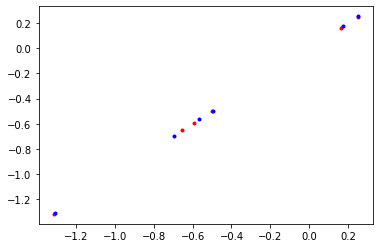

In [127]:
plt.plot(np.linalg.eigvalsh(hams[8]), np.linalg.eigvalsh(pred_dense[8]), 'r.')
plt.plot(np.linalg.eigvalsh(hams[18]), np.linalg.eigvalsh(pred_dense[18]), 'b.')

In [100]:
np.linalg.eigvalsh(pred_dense[18])

array([-1.31139601, -0.69621279, -0.56518852, -0.49694029,  0.17404388,
        0.25307653])

rotated features for a rotated molecule

In [115]:
rot_frame = frames[0].copy()
rot_frame.positions = 50+(50-frames[0].positions[:,[2,0,1]])
rot_frame.positions[:,]

array([[50.      , 50.      , 50.      ],
       [50.      , 49.165109, 50.      ],
       [50.      , 49.905969, 49.038666]])

In [116]:
rhoi = spex.compute([rot_frame])

In [117]:
gij = pairs.compute([rot_frame])

In [118]:
rot_rho1i = acdc_standardize_keys(rhoi)
rot_rho1i.keys_to_properties(['species_neighbor'])
rot_gij =  acdc_standardize_keys(gij)

In [119]:
rot_rho2i = cg_increment(rot_rho1i, rot_rho1i, lcut=4, other_keys_match=["species_center"])

In [120]:
rot_rho3i = cg_increment(rot_rho2i, rot_rho1i, lcut=4, other_keys_match=["species_center"])

In [121]:
rot_rho1ij = cg_increment(rot_rho1i, rot_gij, lcut=4, other_keys_match=["species_center"])

In [122]:
rot_rho2ij = cg_increment(rot_rho2i, rot_gij, lcut=4, other_keys_match=["species_center"])

In [123]:
rot_feats = mk_hamiltonian_feats(rot_rho3i, rot_rho2ij)

In [124]:
rot_pred = FR.predict(rot_feats)

In [125]:
rot_decoupled = decouple_blocks(rot_pred)
rot_dense = blocks_to_dense(rot_decoupled, [rot_frame], orbs)

In [126]:
np.linalg.eigvalsh(pred_dense[0])

array([-1.37730419, -0.69024968, -0.61827408, -0.51012916,  0.17444351,
        0.26734281])

In [127]:
np.linalg.eigvalsh(rot_dense[0])

array([-1.37730419, -0.69024968, -0.61827408, -0.51012916,  0.17444351,
        0.26734281])

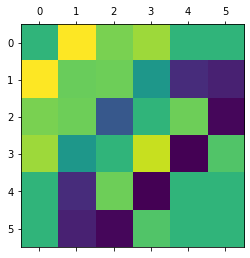

In [128]:
plt.matshow(pred_dense[0]- rot_dense[0])

In [129]:
pred_dense[0]- rot_dense[0]

array([[-1.11022302e-16,  2.21542357e-01,  9.41524949e-02,
         1.27389862e-01, -3.33066907e-16,  1.66533454e-16],
       [ 2.21542357e-01,  7.44437321e-02,  7.99481173e-02,
        -7.99481173e-02, -3.37210824e-01, -3.58932810e-01],
       [ 9.41524949e-02,  7.99481173e-02, -2.42516214e-01,
         0.00000000e+00,  8.02670822e-02, -4.06783377e-01],
       [ 1.27389862e-01, -7.99481173e-02,  0.00000000e+00,
         1.68072482e-01, -4.17477906e-01,  4.78505673e-02],
       [-3.33066907e-16, -3.37210824e-01,  8.02670822e-02,
        -4.17477906e-01,  1.16573418e-15,  5.55111512e-17],
       [ 1.66533454e-16, -3.58932810e-01, -4.06783377e-01,
         4.78505673e-02,  5.55111512e-17, -5.55111512e-17]])